# Sparkify Project Workspace
This workspace contains the **medium-sized dataset** and has been analyzed using a spark cluster through IBM Watson Studio.

In [1]:
# import libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window

from pyspark.sql.functions import *
from pyspark.sql.types import *

import numpy as np
import pandas as pd
import datetime
from time import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import (NaiveBayes, LogisticRegression, DecisionTreeClassifier, 
                                       RandomForestClassifier, LinearSVC)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200116131213-0000
KERNEL_ID = 37fc4a81-49bd-47f7-a7aa-62a0abbfab7d


In [2]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': '',
    'service_id': '',
    'iam_service_endpoint': '',
    'api_key': ''
}

configuration_name = ''
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-bkmbtik7vez6ta'))
df.take(1)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')]

In [3]:
# Set color palette for graphs
sns.set_palette('pastel')

In [4]:
# show all columns of pandas dataframes, adjust column and display width automatically in notebook
# source: https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [5]:
def prepare_data(df):
    '''
    Function that:
    - does some initial dataset analysis before cleaning it
    - removes rows with no user related data
    - converts columns 'registration' and 'ts' to correct timestamp format
    - splits column 'location' into 'location_name' and 'state'
    - creates column 'churn' and sets 'churn' (1) or 'active' (0) for all rows
    - calculates and adds new columns to be used in modeling
    - created new dataset (df_ml) including only the latest event row per user and 
      columns to be used in modeling, all NaNs filled with 0
    
    INPUT:
    df (pyspark dataframe)
    
    OUTPUT:
    df_ml (pyspark dataframe) - only including latest event row per user and
    columns to be used in modeling, all NaNs replaced with 0,
    with added columns:
    
    total_events: Number of events per user
    total_sessions: Number of sessions per user
    avg_session_length: Average session length in hours per user
    days_registered: Number of days registered per user
    unique_artists: Number of unique artists played per user
    unique_songs: Number of unique songs played to per user
    total_nextsong: Number of 'page = NextSong' counts per user
    total_thumbsup: Number of 'page = Thumbs Up' counts per user
    total_home: Number of 'page = Home' counts per user
    total_addfriend: Number of 'page = Add Friend' counts per user
    total_rolladvert: Number of 'page = Roll Advert' counts per user
    '''
    # DATASET STRUCTURE
    print('Dataset structure:')
    df.printSchema()
    
    print('')
    
    # TOTAL NUMBER OF EVENTS
    print('Total number of events in dataset: {}'.format(df.count()))
    
    print('')
    
    # FIND MISSING DATA
    # find NaNs and Nulls in dataframe
    print('Columns with NaNs and Nulls in dataset:')
    df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
    
    print('')
    
    # find empty strings in dataframe
    print('Columns with empty strings in dataset:')
    df.select([count(when(col(c) == '', c)).alias(c) for c in df.columns]).show()
    
    print('')
    
    # CONVERT 'REGISTRATION' AND 'TS' TO TIMESTAMP FORMAT
    # udf to convert timestamp to correct format
    get_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))

    # apply udf to registration timestamp
    df = df.withColumn('registration', get_timestamp(df['registration']))

    # apply udf to ts timestamp
    df = df.withColumn('ts', get_timestamp(df['ts']))
    
    # get time period for all events in dataset
    print('Time period for all events in dataset:')
    df.groupBy(year('ts'), month('ts')).count().sort(month('ts')).show()

    # REMOVE ROWS WITH NO USER RELATED DATA
    df_clean = df.where(col('userId') != '')
    
    # CREATE 'CHURN' AND SET 'YES' OR 'NO' FOR ALL ROWS
    # churn = 1 (yes) if column page = 'Cancellation Confirmation', else 0 (No)
    df_clean = df_clean.withColumn('churn', when(col('page') == 'Cancellation Confirmation', 1).otherwise(0))

    # get userId's where churn = 1
    churned_users = df_clean.select('userId').where(col('churn') == 1).groupby('userId').count()

    # only keep values from 'userId' column and store as list
    churned_users = [row['userId'] for row in churned_users.collect()]

    # set column 'churn' as 1 for all rows for a churned user
    df_clean = df_clean.withColumn('churn', when((df_clean.userId).isin(churned_users), 1).otherwise(0))
    
    # EVENTS PER PAGE TYPE PER USER GROUP
    # plot results as proportions instead of counts
    plt.figure(figsize=(15,10))

    df_page_pd = df_clean.select('churn', 'page').toPandas()
    x, y, hue = 'page', 'proportion', 'churn'
    hue_order = ['Active users', 'Churned users']

    (df_page_pd[x]
     .groupby(df_page_pd[hue])
     .value_counts(normalize=True)
     .rename(y)
     .reset_index()
     .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue))

    plt.legend(loc='upper right', title='Churn')
    plt.title('Number of events per page type (proportion of user group)')
    plt.xlabel('Page')
    plt.ylabel('Proportion')
    plt.xticks(rotation=90)
    plt.show()
    
    print('')

    print('Number of events per page type for all events with a churned user:')
    df_clean.where(col('churn') == 1).groupBy('page').count().sort(desc('count')).show()

    print('Number of events per page type for all events with active users:')
    df_clean.where(col('churn') == 0).groupBy('page').count().sort(desc('count')).show()
    
    print('')
    
    # DISTRIBUTION OF CHURNED AND ACTIVE USERS PER PLAN TYPE
    # percent paid and free plans of churned users
    print('Share of churned users that are on a paid plan: {:.0f}%'.format(
    df_clean.where((df_clean.level == 'paid') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId', 'level').count().count() * 100))

    print('Share of churned users that are on a free plan: {:.0f}%'.format(
    df_clean.where((df_clean.level == 'free') & (df_clean.churn == 1)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 1).groupBy('userId', 'level').count().count() * 100))

    print('')

    # percent paid and free plans of active users
    print('Share of active users that are on a paid plan: {:.0f}%'.format(
    df_clean.where((df_clean.level == 'paid') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId', 'level').count().count() * 100))

    print('Share of active users that are on a free plan: {:.0f}%'.format(
    df_clean.where((df_clean.level == 'free') & (df_clean.churn == 0)).groupBy('userId').count().count() /
    df_clean.where(df_clean.churn == 0).groupBy('userId', 'level').count().count() * 100))
    
    # SPLIT 'LOCATION' INTO TWO:'LOCATION_NAME' AND 'STATE'
    df_clean = df_clean.withColumn('location_name', split(col('location'), ',').getItem(0))
    df_clean = df_clean.withColumn('state', split(col('location'), ',').getItem(1))
    # keep only the first state
    df_clean = df_clean.withColumn('state', split(col('state'), '-').getItem(0))
    
    # CALCULATE AND ADD NEW COLUMNS
    # create partitions
    w1 = Window.partitionBy('userId')
    w2 = Window.partitionBy('userId', 'sessionId')
    w3 = Window.partitionBy('userId', 'artist')
    w4 = Window.partitionBy('userId', 'song')
    
    # TOTAL_EVENTS - column with total number of events per user
    # create dataframe with row counts per user
    df_events = df_clean.select('userId', count('userId').over(w1).alias('total_events')).distinct()
    df_events = df_events.select(col('userId').alias('userId1'), 'total_events')
    
    # TOTAL_SESSIONS - column with total number of sessions per user
    # create dataframe with session counts per user
    df_sessions = df_clean.select('userId', 'sessionId', count('userId').over(w2).alias('count')).distinct()
    df_sessions = df_sessions.withColumn('total_sessions', count('sessionId').over(w1))
    df_sessions = df_sessions.dropDuplicates(['userId'])
    df_sessions = df_sessions.select(col('userId').alias('userId2'), 'total_sessions')

    # MIN_TS_SESSION and MAX_TS_SESSION - columns with timestamp from first and latest event per user and session
    # SESSION_LENGTH - column with session length in hours per session
    # AVG_SESSION_LENGTH - column with average session length per user
    # udf to convert time to correct format and show time difference in hours
    time_delta = udf(lambda y, x: (datetime.datetime.strptime(y, '%Y-%m-%d %H:%M:%S') - 
                                   datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).total_seconds()/3600)

    # create columns with timestamp (ts) from first and latest event per user and session
    df_clean = df_clean.withColumn('min_ts_session', min('ts').over(w2))
    df_clean = df_clean.withColumn('max_ts_session', max('ts').over(w2))

    # apply udf when creating column with time difference (in hours)
    df_clean = df_clean.withColumn('session_length', time_delta(df_clean['max_ts_session'], 
                                                                df_clean['min_ts_session']).cast('float'))

    # create column with average session length per user (in hours)
    df_clean = df_clean.withColumn('avg_session_length', avg('session_length').over(w1))
    
    # LATEST_TS and DAYS_REGISTERED - columns with timestamp from latest event and with number of days registered
    # create column with timestamp (ts) from latest event per user
    df_clean = df_clean.withColumn('latest_ts', max('ts').over(w1))

    # create column 'days_registered'
    df_clean = df_clean.withColumn('days_registered', datediff(df_clean['latest_ts'], df_clean['registration']))
    
    # UNIQUE_ARTISTS - column with number of unique artists played per user
    # create dataframe with artist counts per user
    df_artist = df_clean.select('userId', 'artist', count('userId').over(w3).alias('count')).distinct()
    df_artist = df_artist.withColumn('unique_artists', count('artist').over(w1))
    df_artist = df_artist.dropDuplicates(['userId'])
    df_artist = df_artist.select(col('userId').alias('userId3'), 'unique_artists')
    
    # UNIQUE_SONGS - column with number of unique songs played per user
    # create dataframe with song counts per user
    df_song = df_clean.select('userId', 'song', count('userId').over(w4).alias('count')).distinct()
    df_song = df_song.withColumn('unique_songs', count('song').over(w1))
    df_song = df_song.dropDuplicates(['userId'])
    df_song = df_song.select(col('userId').alias('userId4'), 'unique_songs')
    
    # TOTAL_NEXTSONG - column with number of 'NextSong' events per user
    # create dataframe with 'page = NextSong' counts per user
    df_nextsong = df_clean.where(df_clean.page == 'NextSong').select(
        'userId', count('userId').over(w1).alias('total_nextsong')).distinct()
    df_nextsong = df_nextsong.select(col('userId').alias('userId5'), 'total_nextsong')
    
    # TOTAL_THUMBSUP - column with number of 'Thumbs Up' events per user
    # create dataframe with 'page = Thumbs Up' counts per user
    df_thumbsup = df_clean.where(df_clean.page == 'Thumbs Up').select(
        'userId', count('userId').over(w1).alias('total_thumbsup')).distinct()
    df_thumbsup = df_thumbsup.select(col('userId').alias('userId6'), 'total_thumbsup')
    
    # TOTAL_HOME - column with number of 'Home' events per user
    # create dataframe with 'page = Home' counts per user
    df_home = df_clean.where(df_clean.page == 'Home').select(
        'userId', count('userId').over(w1).alias('total_home')).distinct()
    df_home = df_home.select(col('userId').alias('userId7'), 'total_home')
    
    # TOTAL_ADDFRIEND - column with number of 'Add Friend' events per user
    # create dataframe with 'page = Add Friend' counts per user
    df_addfriend = df_clean.where(df_clean.page == 'Add Friend').select(
        'userId', count('userId').over(w1).alias('total_addfriend')).distinct()
    df_addfriend = df_addfriend.select(col('userId').alias('userId8'), 'total_addfriend')
    
    # TOTAL_ROLLADVERT - column with number of 'Roll Advert' events per user
    # create dataframe with 'page = Roll Advert' counts per user
    df_rolladvert = df_clean.where(df_clean.page == 'Roll Advert').select(
        'userId', count('userId').over(w1).alias('total_rolladvert')).distinct()
    df_rolladvert = df_rolladvert.select(col('userId').alias('userId9'), 'total_rolladvert')
    
    # LATEST EVENT - column indicating row with latest event per user
    df_clean = df_clean.withColumn('latest_event', when(df_clean.latest_ts == df_clean.ts, 1).otherwise(0))
    
    # MODELING PREPARATION
    # KEEP ONLY ROW WITH LATEST EVENT PER USER IN DATA TO BE USED FOR MODELING
    df_ml = df_clean.where(col('latest_event') == 1)
    
    # DROP DUPLICATES FROM DATAFRAME
    df_ml = df_ml.dropDuplicates(['userId'])
    
    # RECODE 'GENDER' TO NUMERICAL BINARY
    df_ml = df_ml.withColumn('gender', when(df_ml.gender == 'F', 1).otherwise(0))
    
    # ONLY KEEEP COLUMNS TO BE USED IN MODELING AND REPLACE NAN WITH 0
    df_ml = df_ml.select('userId', 'churn', 'gender', 'state', 'avg_session_length', 
                         'days_registered', ).fillna(0)
    
    # ADD COLUMNS TO DF_ML DATAFRAME AND REPLACE NAN WITH 0 FOR COLUMN
    # add column 'total_events'
    df_ml = df_ml.join(df_events, df_ml.userId == df_events.userId1, how='left').select(
        df_ml['*'], df_events['total_events']).fillna(0, subset=['total_events'])
    
    # add column 'total_sessions'
    df_ml = df_ml.join(df_sessions, df_ml.userId == df_sessions.userId2, how='left').select(
        df_ml['*'], df_sessions['total_sessions']).fillna(0, subset=['total_sessions'])

    # add column 'unique_artists'
    df_ml = df_ml.join(df_artist, df_ml.userId == df_artist.userId3, how='left').select(
        df_ml['*'], df_artist['unique_artists']).fillna(0, subset=['unique_artists'])
    
    # add column 'unique_songs'
    df_ml = df_ml.join(df_song, df_ml.userId == df_song.userId4, how='left').select(
        df_ml['*'], df_song['unique_songs']).fillna(0, subset=['unique_songs'])
    
    # add column 'total_nextsong'
    df_ml = df_ml.join(df_nextsong, df_ml.userId == df_nextsong.userId5, how='left').select(
        df_ml['*'], df_nextsong['total_nextsong']).fillna(0, subset=['total_nextsong'])
    
    # add column 'total_thumbsup'
    df_ml = df_ml.join(df_thumbsup, df_ml.userId == df_thumbsup.userId6, how='left').select(
        df_ml['*'], df_thumbsup['total_thumbsup']).fillna(0, subset=['total_thumbsup'])
    
    # add column 'total_home'
    df_ml = df_ml.join(df_home, df_ml.userId == df_home.userId7, how='left').select(
        df_ml['*'], df_home['total_home']).fillna(0, subset=['total_home'])
    
    # add column 'total_addfriend'
    df_ml = df_ml.join(df_addfriend, df_ml.userId == df_addfriend.userId8, how='left').select(
        df_ml['*'], df_addfriend['total_addfriend']).fillna(0, subset=['total_addfriend'])
    
    # add column 'total_rolladvert'
    df_ml = df_ml.join(df_rolladvert, df_ml.userId == df_rolladvert.userId9, how='left').select(
        df_ml['*'], df_rolladvert['total_rolladvert']).fillna(0, subset=['total_rolladvert'])
    
    return df_ml

Dataset structure:
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)


Total number of events in dataset: 543705

Columns with NaNs and Nulls in dataset:
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|len

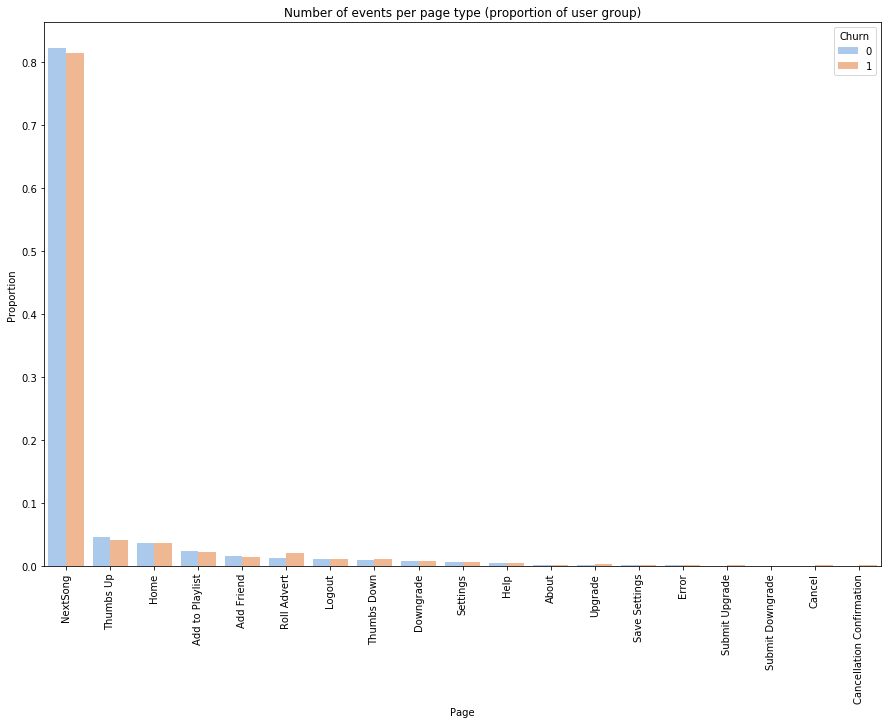


Number of events per page type for all events with a churned user:
+--------------------+-----+
|                page|count|
+--------------------+-----+
|            NextSong|84359|
|           Thumbs Up| 4300|
|                Home| 3778|
|     Add to Playlist| 2259|
|         Roll Advert| 2186|
|          Add Friend| 1537|
|              Logout| 1184|
|         Thumbs Down| 1156|
|           Downgrade|  831|
|            Settings|  619|
|                Help|  517|
|             Upgrade|  237|
|               About|  185|
|       Save Settings|  104|
|              Cancel|   99|
|Cancellation Conf...|   99|
|               Error|   97|
|      Submit Upgrade|   70|
|    Submit Downgrade|   29|
+--------------------+-----+

Number of events per page type for all events with active users:
+----------------+------+
|            page| count|
+----------------+------+
|        NextSong|348518|
|       Thumbs Up| 19526|
|            Home| 15311|
| Add to Playlist| 10090|
|      Add Friend

In [6]:
df_ml = prepare_data(df)

In [7]:
# cache dataset and print structure
df_ml.cache()
df_ml.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- gender: integer (nullable = false)
 |-- state: string (nullable = true)
 |-- avg_session_length: double (nullable = false)
 |-- days_registered: integer (nullable = true)
 |-- total_events: long (nullable = true)
 |-- total_sessions: long (nullable = true)
 |-- unique_artists: long (nullable = true)
 |-- unique_songs: long (nullable = true)
 |-- total_nextsong: long (nullable = true)
 |-- total_thumbsup: long (nullable = true)
 |-- total_home: long (nullable = true)
 |-- total_addfriend: long (nullable = true)
 |-- total_rolladvert: long (nullable = true)



In [8]:
def plot_data(df_ml):
    '''
    Function that:
    - gives information of number of total, churned and active users
    - plots and gives information on gender proportions per user group
    - plots and gives information on location (state) proportions per user group
    - plots boxplots and gives basic statistics of churned and active users for columns:
        total_events
        total_sessions
        avg_session_length
        days_registered
        unique_artists
        unique_songs
        total_nextsong
        total_thumbsup
        total_home
        total_addfriend
        total_rolladvert  
    - plots correlation matrix of numerical columns

    INPUT:
    df_ml (pyspark dataframe)
    
    OUTPUT:
    none
    '''
    # USER STATS - TOTAL, CHURNED AND ACTIVE USERS
    # total number of users
    print('Total number of users: {}'.format(df_ml.count()))

    # number of churned users
    print('Number of churned users: {}'.format(
    df_ml.where(col('churn') == 1).count()))

    # number of active users
    print('Number of active users: {}'.format(
    df_ml.where(col('churn') == 0).count()))
    
    print('')
    
    # GENDER
    # graph of gender distribution for churned and active users
    plt.figure(figsize=(15,10))

    df_gender_pd = df_ml.select('churn', 'gender').toPandas()
    x, y, hue = 'gender', 'proportion', 'churn'
    hue_order = ['Active users', 'Churned users']

    (df_gender_pd[x]
     .groupby(df_gender_pd[hue])
     .value_counts(normalize=True)
     .rename(y)
     .reset_index()
     .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue))

    plt.legend(loc='upper right', title='Churn')
    plt.title('Gender distribution (proportion of user group)')
    plt.xlabel('Gender')
    plt.ylabel('Proportion')
    plt.show()

    print('')

    # percent males and females of churned users
    print('Share of churned users that are male: {:.0f}%'.format(
        df_ml.where((df_ml.gender == 0) & (df_ml.churn == 1)).count() /
        df_ml.where(df_ml.churn == 1).count() * 100))

    print('Share of churned users that are female: {:.0f}%'.format(
        df_ml.where((df_ml.gender == 1) & (df_ml.churn == 1)).count() /
        df_ml.where(df_ml.churn == 1).count() * 100))

    print('')

    # percent males and females of active users
    print('Share of active users that are male: {:.0f}%'.format(
        df_ml.where((df_ml.gender == 0) & (df_ml.churn == 0)).count() /
        df_ml.where(df_ml.churn == 0).count() * 100))

    print('Share of active users that are female: {:.0f}%'.format(
        df_ml.where((df_ml.gender == 1) & (df_ml.churn == 0)).count() /
        df_ml.where(df_ml.churn == 0).count() * 100))
    
    print('')
    
    # STATE
    # graph of location distribution for churned and active users
    plt.figure(figsize=(18,12))

    df_location_pd = df_ml.select('churn', 'state').toPandas()
    x, y, hue = 'state', 'proportion', 'churn'
    hue_order = ['Active users', 'Churned users']

    (df_location_pd[x]
     .groupby(df_location_pd[hue])
     .value_counts(normalize=True)
     .rename(y)
     .reset_index()
     .pipe((sns.barplot, 'data'), x=x, y=y, hue=hue))

    plt.legend(loc='upper right', title='Churn')
    plt.title('Location distribution (proportion of user group)')
    plt.xlabel('State')
    plt.ylabel('Proportion')
    plt.xticks(rotation=90)
    plt.show()

    print('')

    print('States for churned users:')
    df_ml.where(col('churn') == 1).groupBy('state').count().sort(desc('count')).show(40)

    print('States for active users:')
    df_ml.where(col('churn') == 0).groupBy('state').count().sort(desc('count')).show(40)
    
    print('')
    
    # TOTAL_EVENTS
    # store column values as array
    churn = df_ml.select('total_events').where(df_ml['churn'] == 1).toPandas().values.tolist()
    active = df_ml.select('total_events').where(df_ml['churn'] == 0).toPandas().values.tolist()

    # plot boxplots of both arrays in the same plot
    data = [churn, active]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(data)
    ax.set_xticklabels(['Churned', 'Active'])
    plt.title('Total events')
    plt.show()

    # plot basic statistics
    print('Basic statistics for churned users:')
    df_ml.select('total_events').where(df_ml['churn'] == 1).summary().show()
    print('Basic statistics for active users:')
    df_ml.select('total_events').where(df_ml['churn'] == 0).summary().show()

    print('')
    
    # TOTAL_SESSIONS
    # store column values as array
    churn = df_ml.select('total_sessions').where(df_ml['churn'] == 1).toPandas().values.tolist()
    active = df_ml.select('total_sessions').where(df_ml['churn'] == 0).toPandas().values.tolist()

    # plot boxplots of both arrays in the same plot
    data = [churn, active]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(data)
    ax.set_xticklabels(['Churned', 'Active'])
    plt.title('Total sessions')
    plt.show()

    # plot basic statistics
    print('Basic statistics for churned users:')
    df_ml.select('total_sessions').where(df_ml['churn'] == 1).summary().show()
    print('Basic statistics for active users:')
    df_ml.select('total_sessions').where(df_ml['churn'] == 0).summary().show()

    print('')
    
    # AVG_SESSION_LENGTH
    # store columns to be used as pandas dataframe
    df_avg_pd = df_ml.select('churn', 'avg_session_length').toPandas()
    
    # plot histogram of both lists in the same plot
    plt.figure(figsize=(15,10))
    plt.hist(df_avg_pd['avg_session_length'][df_avg_pd['churn'] == 0], label='Active users')
    plt.hist(df_avg_pd['avg_session_length'][df_avg_pd['churn'] == 1], label='Churned users')
    plt.legend(loc='upper right')
    plt.title('Average session length (hours)')
    plt.xlabel('Average session length per user (hours)')
    plt.ylabel('Count')
    plt.show()

    print('')
    
    # store column values as list
    churn = df_ml.select('avg_session_length').where(df_ml['churn'] == 1).toPandas().values.tolist()
    active = df_ml.select('avg_session_length').where(df_ml['churn'] == 0).toPandas().values.tolist()

    # plot boxplots of both lists in the same plot
    data = [churn, active]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(data)
    ax.set_xticklabels(['Churned', 'Active'])
    plt.title('Average session length (hours)')
    plt.show()

    # plot basic statistics
    print('Basic statistics for churned users:')
    df_ml.select('avg_session_length').where(df_ml['churn'] == 1).summary().show()
    print('Basic statistics for active users:')
    df_ml.select('avg_session_length').where(df_ml['churn'] == 0).summary().show()

    print('')
    
    # DAYS_REGISTERED
    # store columns to be used as pandas dataframe
    df_reg_pd = df_ml.select('churn', 'days_registered').toPandas()
    
    # plot histogram of both lists in the same plot
    plt.figure(figsize=(15,10))
    plt.hist(df_reg_pd['days_registered'][df_reg_pd['churn'] == 0], label='Active users')
    plt.hist(df_reg_pd['days_registered'][df_reg_pd['churn'] == 1], label='Churned users')
    plt.legend(loc='upper right')
    plt.title('Days registered')
    plt.xlabel('Number of days registered per user')
    plt.ylabel('Count')
    plt.show()

    print('')
    
    # store column values as list
    churn = df_ml.select('days_registered').where(df_ml['churn'] == 1).toPandas().values.tolist()
    active = df_ml.select('days_registered').where(df_ml['churn'] == 0).toPandas().values.tolist()
    
    # plot boxplots of both lists in the same plot
    data = [churn, active]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(data)
    ax.set_xticklabels(['Churned', 'Active'])
    plt.title('Days registered')
    plt.show()

    # plot basic statistics
    print('Basic statistics for churned users:')
    df_ml.select('days_registered').where(df_ml['churn'] == 1).summary().show()
    print('Basic statistics for active users:')
    df_ml.select('days_registered').where(df_ml['churn'] == 0).summary().show()

    print('')
    
    # UNIQUE ARTISTS
    # store column values as list
    churn = df_ml.select('unique_artists').where(df_ml['churn'] == 1).toPandas().values.tolist()
    active = df_ml.select('unique_artists').where(df_ml['churn'] == 0).toPandas().values.tolist()

    # plot boxplots of both lists in the same plot
    data = [churn, active]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(data)
    ax.set_xticklabels(['Churned', 'Active'])
    plt.title('Unique artists')
    plt.show()

    # plot basic statistics
    print('Basic statistics for churned users:')
    df_ml.select('unique_artists').where(df_ml['churn'] == 1).summary().show()
    print('Basic statistics for active users:')
    df_ml.select('unique_artists').where(df_ml['churn'] == 0).summary().show()

    print('')
    
    # plot UNIQUE_SONGS
    # store column values as list
    churn = df_ml.select('unique_songs').where(df_ml['churn'] == 1).toPandas().values.tolist()
    active = df_ml.select('unique_songs').where(df_ml['churn'] == 0).toPandas().values.tolist()

    # plot boxplots of both lists in the same plot
    data = [churn, active]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(data)
    ax.set_xticklabels(['Churned', 'Active'])
    plt.title('Unique songs')
    plt.show()

    # plot basic statistics
    print('Basic statistics for churned users:')
    df_ml.select('unique_songs').where(df_ml['churn'] == 1).summary().show()
    print('Basic statistics for active users:')
    df_ml.select('unique_songs').where(df_ml['churn'] == 0).summary().show()

    print('')
    
    # plot TOTAL_NEXTSONG
    # store column values as list
    churn = df_ml.select('total_nextsong').where(df_ml['churn'] == 1).toPandas().values.tolist()
    active = df_ml.select('total_nextsong').where(df_ml['churn'] == 0).toPandas().values.tolist()

    # plot boxplots of both lists in the same plot
    data = [churn, active]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(data)
    ax.set_xticklabels(['Churned', 'Active'])
    plt.title('Total NextSong')
    plt.show()

    # plot basic statistics
    print('Basic statistics for churned users:')
    df_ml.select('total_nextsong').where(df_ml['churn'] == 1).summary().show()
    print('Basic statistics for active users:')
    df_ml.select('total_nextsong').where(df_ml['churn'] == 0).summary().show()

    print('')
    
    # TOTAL_THUMBSUP
    # store column values as list
    churn = df_ml.select('total_thumbsup').where(df_ml['churn'] == 1).toPandas().values.tolist()
    active = df_ml.select('total_thumbsup').where(df_ml['churn'] == 0).toPandas().values.tolist()

    # plot boxplots of both lists in the same plot
    data = [churn, active]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(data)
    ax.set_xticklabels(['Churned', 'Active'])
    plt.title('Total Thumbs Up')
    plt.show()

    # plot basic statistics
    print('Basic statistics for churned users:')
    df_ml.select('total_thumbsup').where(df_ml['churn'] == 1).summary().show()
    print('Basic statistics for active users:')
    df_ml.select('total_thumbsup').where(df_ml['churn'] == 0).summary().show()

    print('')
    
    # TOTAL_HOME
    # store column values as list
    churn = df_ml.select('total_home').where(df_ml['churn'] == 1).toPandas().values.tolist()
    active = df_ml.select('total_home').where(df_ml['churn'] == 0).toPandas().values.tolist()

    # plot boxplots of both lists in the same plot
    data = [churn, active]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(data)
    ax.set_xticklabels(['Churned', 'Active'])
    plt.title('Total home')
    plt.show()

    # plot basic statistics
    print('Basic statistics for churned users:')
    df_ml.select('total_home').where(df_ml['churn'] == 1).summary().show()
    print('Basic statistics for active users:')
    df_ml.select('total_home').where(df_ml['churn'] == 0).summary().show()

    print('')
    
    # TOTAL_ADDFRIEND
    # store column values as list
    churn = df_ml.select('total_addfriend').where(df_ml['churn'] == 1).toPandas().values.tolist()
    active = df_ml.select('total_addfriend').where(df_ml['churn'] == 0).toPandas().values.tolist()

    # plot boxplots of both lists in the same plot
    data = [churn, active]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(data)
    ax.set_xticklabels(['Churned', 'Active'])
    plt.title('Total Add Friend')
    plt.show()

    # plot basic statistics
    print('Basic statistics for churned users:')
    df_ml.select('total_addfriend').where(df_ml['churn'] == 1).summary().show()
    print('Basic statistics for active users:')
    df_ml.select('total_addfriend').where(df_ml['churn'] == 0).summary().show()

    print('')
    
    # TOTAL_ROLLADVERT
    # store column values as list
    churn = df_ml.select('total_rolladvert').where(df_ml['churn'] == 1).toPandas().values.tolist()
    active = df_ml.select('total_rolladvert').where(df_ml['churn'] == 0).toPandas().values.tolist()

    # plot boxplots of both lists in the same plot
    data = [churn, active]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.boxplot(data)
    ax.set_xticklabels(['Churned', 'Active'])
    plt.title('Total Roll Advert')
    plt.show()

    # plot basic statistics
    print('Basic statistics for churned users:')
    df_ml.select('total_rolladvert').where(df_ml['churn'] == 1).summary().show()
    print('Basic statistics for active users:')
    df_ml.select('total_rolladvert').where(df_ml['churn'] == 0).summary().show()

    print('')
    
    # CORRELATION MATRIX OF NUMERICAL COLUMNS
    # create correlation matrix
    df_corr = df_ml.toPandas().corr()

    plt.figure(figsize=(18,15))
    plt.title('Correlation between numerical columns')

    # create a mask for the upper triangle
    mask = np.zeros_like(df_corr)
    mask[np.triu_indices_from(mask)] = True

    # create custom color range for heatmap to match other graphs in notebook
    cmap = mcolors.LinearSegmentedColormap.from_list('n',['#A2C2E6', '#FFFFFF','#EBAF88'])

    sns.heatmap(df_corr, mask=mask, annot=True, linewidths=0.5, cmap=cmap)
    plt.show()

Total number of users: 448
Number of churned users: 99
Number of active users: 349



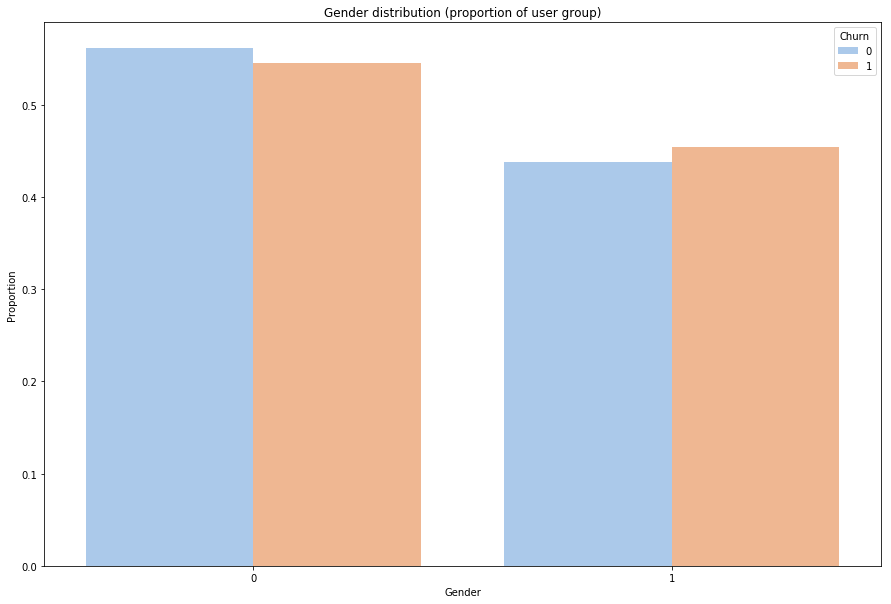


Share of churned users that are male: 55%
Share of churned users that are female: 45%

Share of active users that are male: 56%
Share of active users that are female: 44%



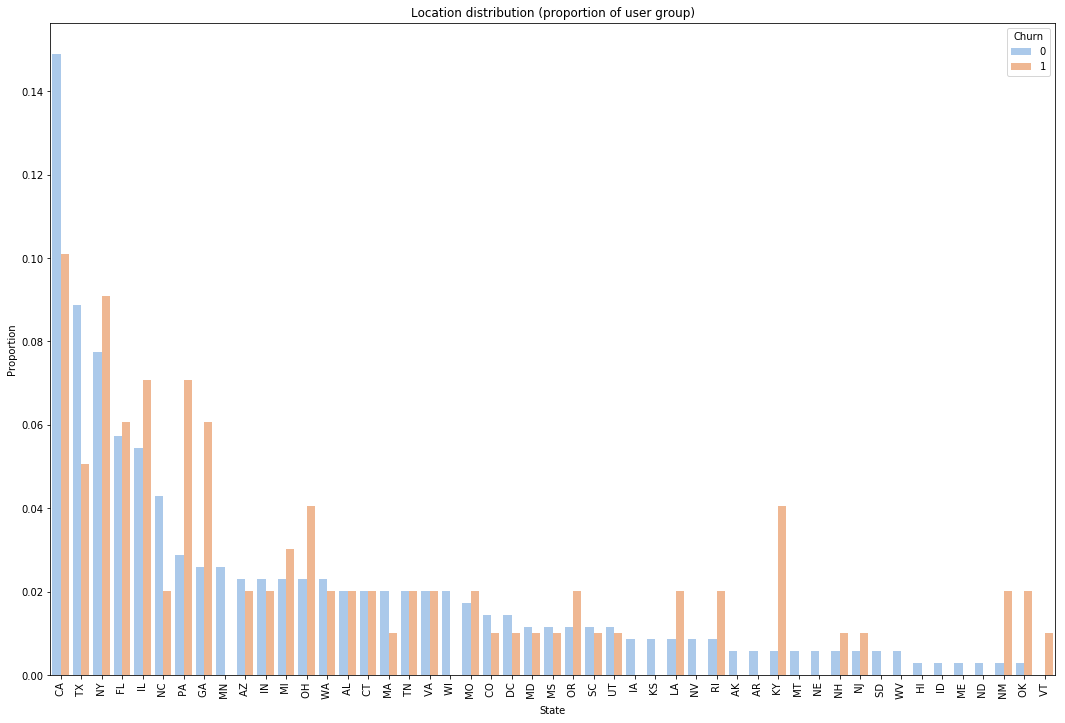


States for churned users:
+-----+-----+
|state|count|
+-----+-----+
|   CA|   10|
|   NY|    9|
|   PA|    7|
|   IL|    7|
|   GA|    6|
|   FL|    6|
|   TX|    5|
|   OH|    4|
|   KY|    4|
|   MI|    3|
|   WA|    2|
|   AL|    2|
|   NM|    2|
|   CT|    2|
|   VA|    2|
|   IN|    2|
|   NC|    2|
|   AZ|    2|
|   LA|    2|
|   OK|    2|
|   TN|    2|
|   OR|    2|
|   RI|    2|
|   MO|    2|
|   VT|    1|
|   NH|    1|
|   MD|    1|
|   UT|    1|
|   MA|    1|
|   NJ|    1|
|   MS|    1|
|   DC|    1|
|   SC|    1|
|   CO|    1|
+-----+-----+

States for active users:
+-----+-----+
|state|count|
+-----+-----+
|   CA|   52|
|   TX|   31|
|   NY|   27|
|   FL|   20|
|   IL|   19|
|   NC|   15|
|   PA|   10|
|   GA|    9|
|   MN|    9|
|   AZ|    8|
|   MI|    8|
|   IN|    8|
|   OH|    8|
|   WA|    8|
|   WI|    7|
|   TN|    7|
|   CT|    7|
|   AL|    7|
|   VA|    7|
|   MA|    7|
|   MO|    6|
|   DC|    5|
|   CO|    5|
|   MD|    4|
|   OR|    4|
|   MS|    4|
|   UT|  

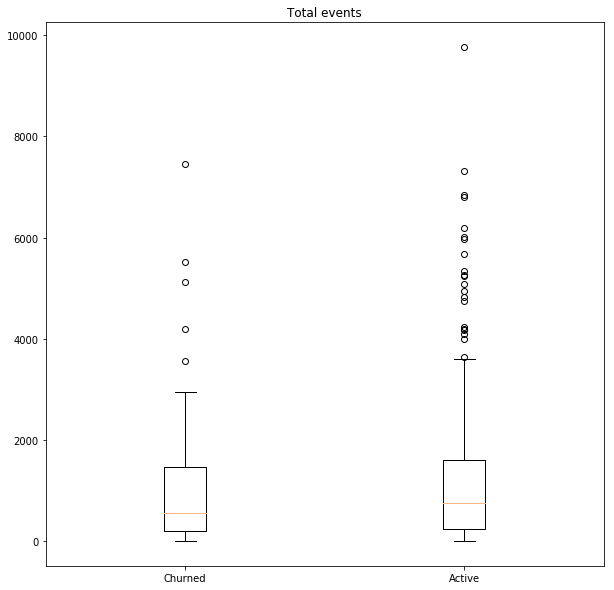

Basic statistics for churned users:
+-------+------------------+
|summary|      total_events|
+-------+------------------+
|  count|                99|
|   mean|1046.9292929292928|
| stddev| 1263.130555830213|
|    min|                13|
|    25%|               204|
|    50%|               558|
|    75%|              1474|
|    max|              7448|
+-------+------------------+

Basic statistics for active users:
+-------+------------------+
|summary|      total_events|
+-------+------------------+
|  count|               349|
|   mean|1215.9283667621776|
| stddev|1411.6511763550188|
|    min|                 3|
|    25%|               245|
|    50%|               756|
|    75%|              1599|
|    max|              9767|
+-------+------------------+




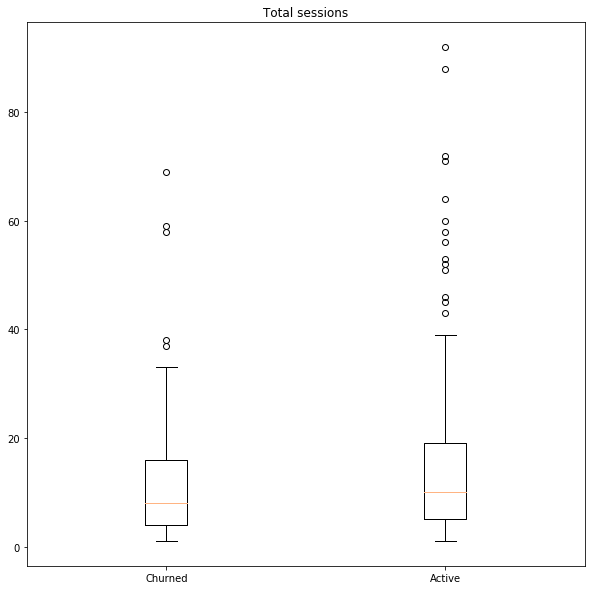

Basic statistics for churned users:
+-------+------------------+
|summary|    total_sessions|
+-------+------------------+
|  count|                99|
|   mean|12.090909090909092|
| stddev|12.683824593078295|
|    min|                 1|
|    25%|                 4|
|    50%|                 8|
|    75%|                16|
|    max|                69|
+-------+------------------+

Basic statistics for active users:
+-------+------------------+
|summary|    total_sessions|
+-------+------------------+
|  count|               349|
|   mean|13.991404011461318|
| stddev|13.293652254533612|
|    min|                 1|
|    25%|                 5|
|    50%|                10|
|    75%|                19|
|    max|                92|
+-------+------------------+




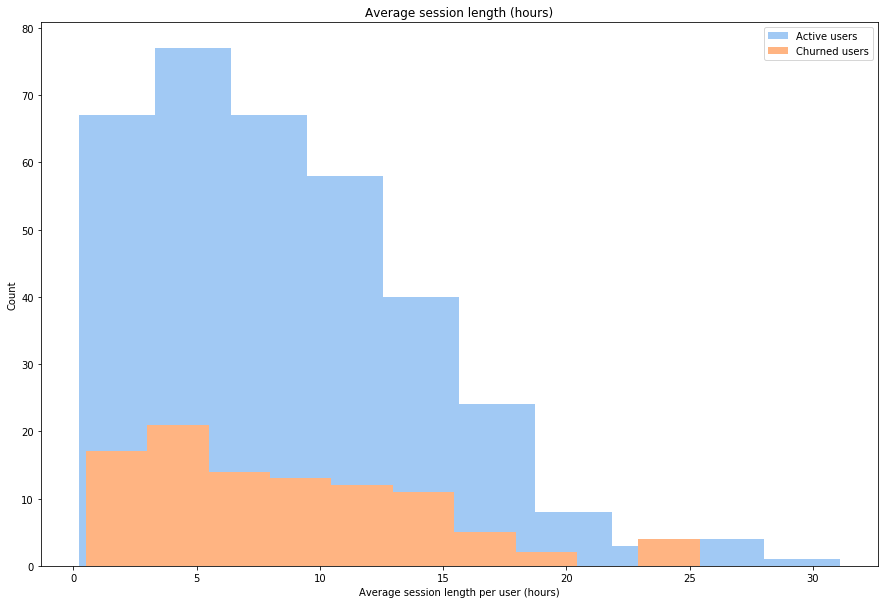

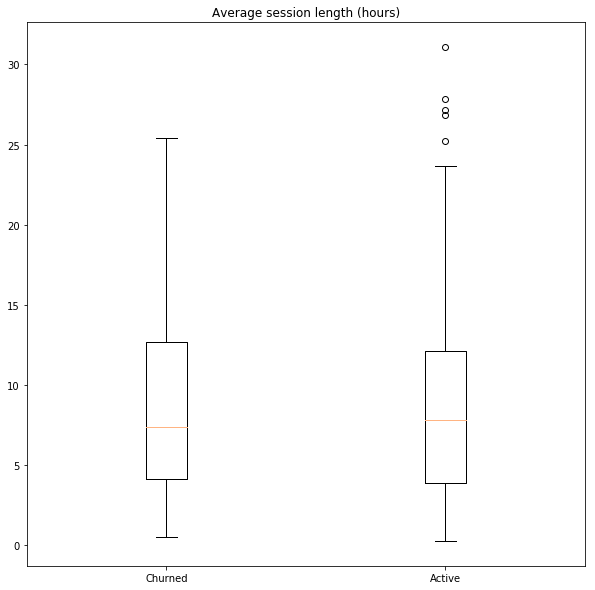

Basic statistics for churned users:
+-------+------------------+
|summary|avg_session_length|
+-------+------------------+
|  count|                99|
|   mean| 8.725451727878108|
| stddev| 5.699734025814647|
|    min|0.4983333349227905|
|    25%| 4.063746174776947|
|    50%| 7.327634195181743|
|    75%|12.690876542044379|
|    max|25.420145721705765|
+-------+------------------+

Basic statistics for active users:
+-------+-------------------+
|summary| avg_session_length|
+-------+-------------------+
|  count|                349|
|   mean|  8.544137408558118|
| stddev|  5.610975190329506|
|    min|0.21944443881511688|
|    25%|  3.865108975689662|
|    50%|  7.790031999041419|
|    75%| 12.118077534399557|
|    max| 31.098625926368417|
+-------+-------------------+




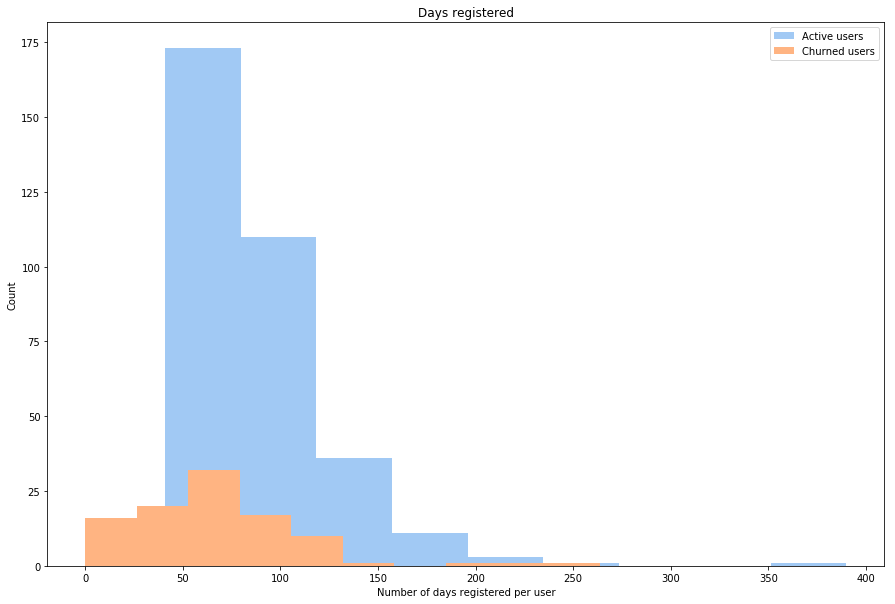

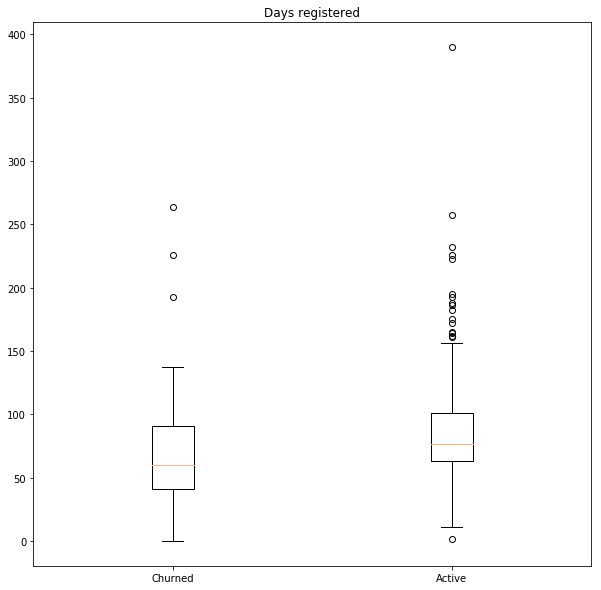

Basic statistics for churned users:
+-------+-----------------+
|summary|  days_registered|
+-------+-----------------+
|  count|               99|
|   mean|68.01010101010101|
| stddev|43.55022785139086|
|    min|                0|
|    25%|               40|
|    50%|               60|
|    75%|               91|
|    max|              264|
+-------+-----------------+

Basic statistics for active users:
+-------+------------------+
|summary|   days_registered|
+-------+------------------+
|  count|               349|
|   mean| 86.98567335243553|
| stddev|38.667865433016445|
|    min|                 2|
|    25%|                63|
|    50%|                77|
|    75%|               101|
|    max|               390|
+-------+------------------+




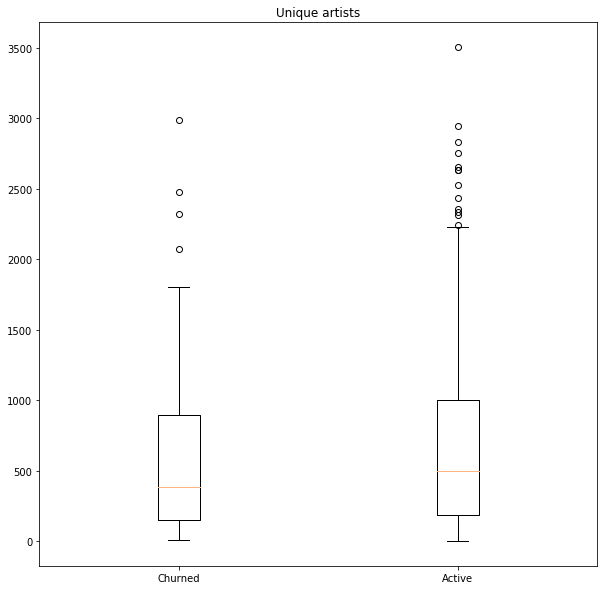

Basic statistics for churned users:
+-------+-----------------+
|summary|   unique_artists|
+-------+-----------------+
|  count|               99|
|   mean|592.7373737373738|
| stddev|586.9310807828724|
|    min|                7|
|    25%|              153|
|    50%|              382|
|    75%|              902|
|    max|             2987|
+-------+-----------------+

Basic statistics for active users:
+-------+-----------------+
|summary|   unique_artists|
+-------+-----------------+
|  count|              349|
|   mean|677.7707736389685|
| stddev|636.0470769415532|
|    min|                1|
|    25%|              183|
|    50%|              499|
|    75%|             1003|
|    max|             3507|
+-------+-----------------+




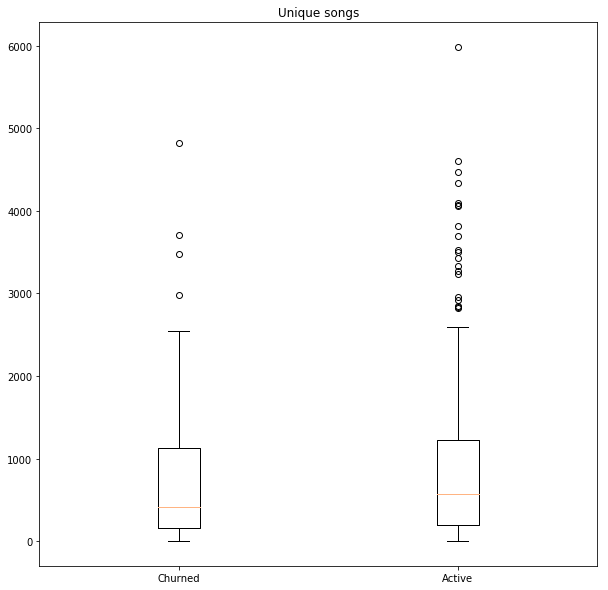

Basic statistics for churned users:
+-------+-----------------+
|summary|     unique_songs|
+-------+-----------------+
|  count|               99|
|   mean|756.6161616161617|
| stddev|863.1545928538576|
|    min|                7|
|    25%|              159|
|    50%|              419|
|    75%|             1132|
|    max|             4825|
+-------+-----------------+

Basic statistics for active users:
+-------+-----------------+
|summary|     unique_songs|
+-------+-----------------+
|  count|              349|
|   mean|879.3782234957021|
| stddev|952.3954645543688|
|    min|                1|
|    25%|              194|
|    50%|              572|
|    75%|             1231|
|    max|             5986|
+-------+-----------------+




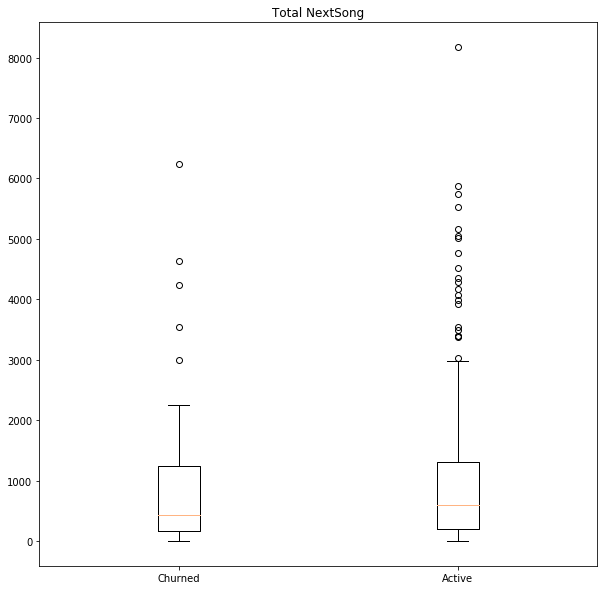

Basic statistics for churned users:
+-------+------------------+
|summary|    total_nextsong|
+-------+------------------+
|  count|                99|
|   mean| 852.1111111111111|
| stddev|1054.7876552806383|
|    min|                 7|
|    25%|               164|
|    50%|               439|
|    75%|              1248|
|    max|              6233|
+-------+------------------+

Basic statistics for active users:
+-------+-----------------+
|summary|   total_nextsong|
+-------+-----------------+
|  count|              349|
|   mean|998.6189111747851|
| stddev|1176.055261421504|
|    min|                1|
|    25%|              196|
|    50%|              601|
|    75%|             1316|
|    max|             8177|
+-------+-----------------+




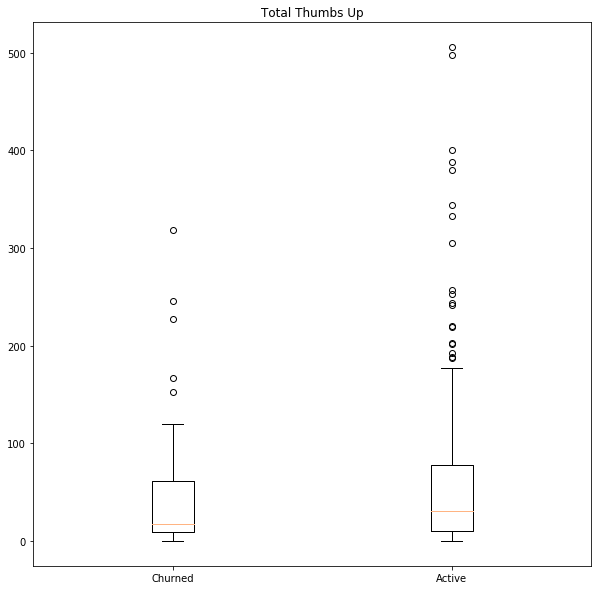

Basic statistics for churned users:
+-------+-----------------+
|summary|   total_thumbsup|
+-------+-----------------+
|  count|               99|
|   mean|43.43434343434343|
| stddev|54.87093606655188|
|    min|                0|
|    25%|                9|
|    50%|               17|
|    75%|               64|
|    max|              319|
+-------+-----------------+

Basic statistics for active users:
+-------+------------------+
|summary|    total_thumbsup|
+-------+------------------+
|  count|               349|
|   mean|55.948424068767906|
| stddev| 73.13672190425345|
|    min|                 0|
|    25%|                10|
|    50%|                31|
|    75%|                78|
|    max|               506|
+-------+------------------+




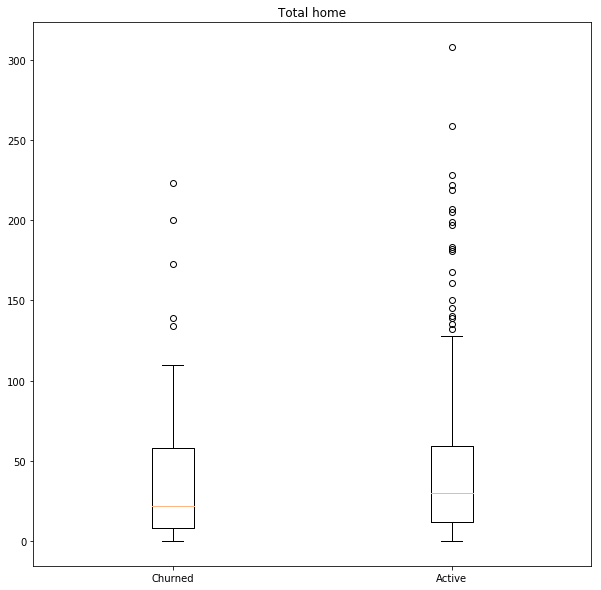

Basic statistics for churned users:
+-------+-----------------+
|summary|       total_home|
+-------+-----------------+
|  count|               99|
|   mean|38.16161616161616|
| stddev|42.53299009405475|
|    min|                0|
|    25%|                7|
|    50%|               22|
|    75%|               58|
|    max|              223|
+-------+-----------------+

Basic statistics for active users:
+-------+-----------------+
|summary|       total_home|
+-------+-----------------+
|  count|              349|
|   mean|43.87106017191977|
| stddev|47.37528084130316|
|    min|                0|
|    25%|               12|
|    50%|               30|
|    75%|               59|
|    max|              308|
+-------+-----------------+




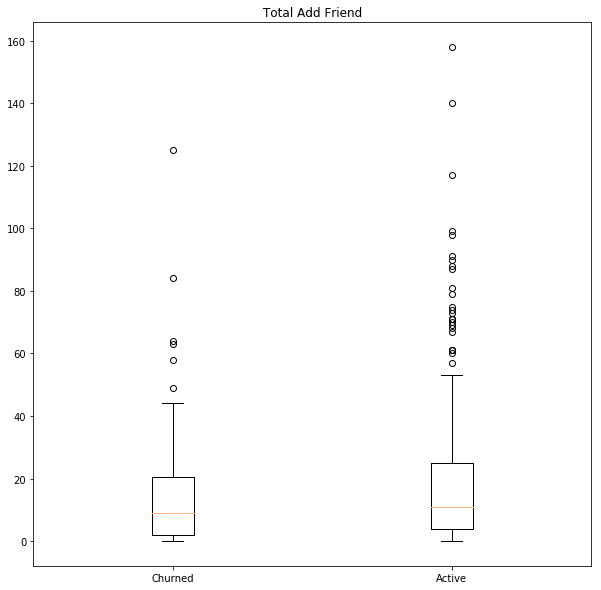

Basic statistics for churned users:
+-------+------------------+
|summary|   total_addfriend|
+-------+------------------+
|  count|                99|
|   mean|15.525252525252526|
| stddev|19.913764819147456|
|    min|                 0|
|    25%|                 2|
|    50%|                 9|
|    75%|                21|
|    max|               125|
+-------+------------------+

Basic statistics for active users:
+-------+-----------------+
|summary|  total_addfriend|
+-------+-----------------+
|  count|              349|
|   mean|18.76790830945559|
| stddev|22.78675511219824|
|    min|                0|
|    25%|                4|
|    50%|               11|
|    75%|               25|
|    max|              158|
+-------+-----------------+




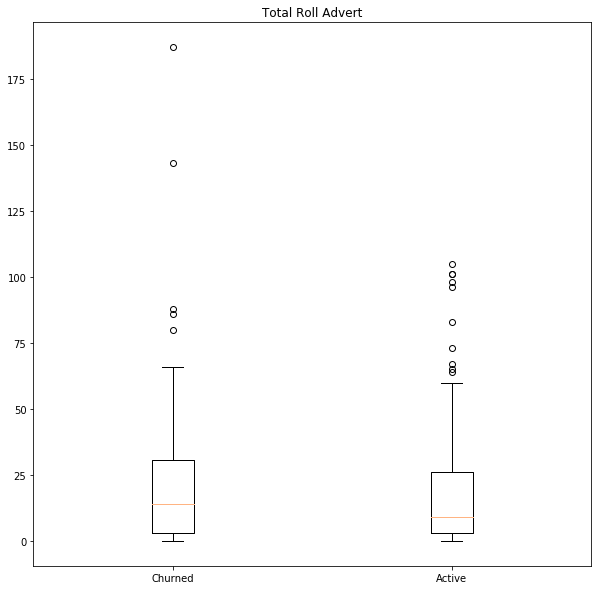

Basic statistics for churned users:
+-------+------------------+
|summary|  total_rolladvert|
+-------+------------------+
|  count|                99|
|   mean| 22.08080808080808|
| stddev|28.335337700575373|
|    min|                 0|
|    25%|                 3|
|    50%|                14|
|    75%|                31|
|    max|               187|
+-------+------------------+

Basic statistics for active users:
+-------+------------------+
|summary|  total_rolladvert|
+-------+------------------+
|  count|               349|
|   mean|16.008595988538683|
| stddev|18.815267569522963|
|    min|                 0|
|    25%|                 3|
|    50%|                 9|
|    75%|                26|
|    max|               105|
+-------+------------------+




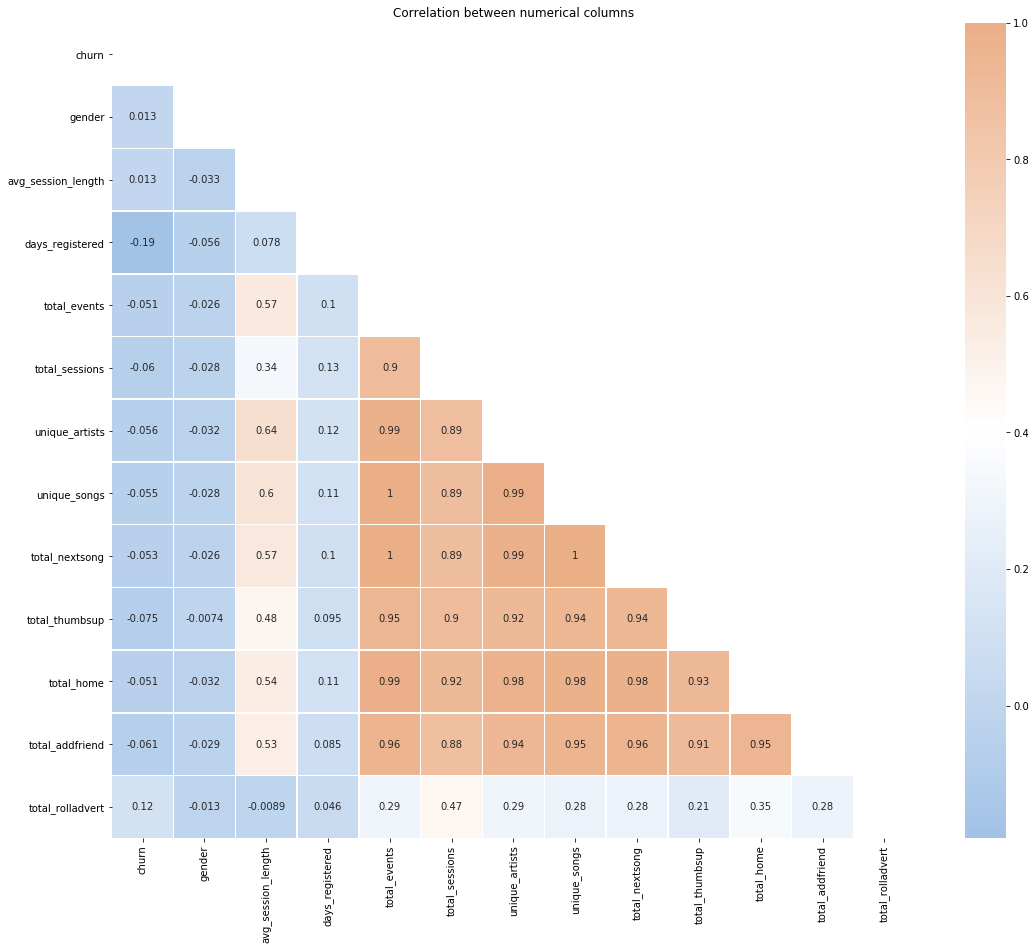

In [9]:
plot_data(df_ml)

**This bigger dataset has the same distribution between the classes, 22% of the dataset are churned users.**

**There is practically no difference in the gender distribution between churned and active users.**

**We only looked at the state distribution for all events in the small dataset, but California (CA) was the most common state for both churned and active users, which is the same here, looking at unique users.**

**When it comes to total number of events (total_events), the mean is higher for churned users with greater variation in the data compared to the small dataset. For active users, the mean is lower but the variation in the data is close to being the same. The user groups are less different for this bigger dataset.**

**The mean for total number of sessions (total_sessions) for churned users is slightly higher but lower for active users. The mean between the user groups here is very similar.**

**The average session length (avg_session_length) is slightly higher for churned users and slightly lower for active user compared to the small dataset. There is practically no difference between the user groups for this bigger dataset.**

**When it comes to the number of days registered on the platform (days_registered), the mean is the same for active users but higher for churned users. There are smaller but still considerable differences between the user groups.**

**There are smaller differences between the users groups for number of unique artists played (unique_artist). Churned users have a higher mean and greater variance in the data, meanwhile active users have a smaller mean.**

**The number of unique songs played (unique_songs) has a higher mean for churned users and a lower mean for active users, and the variance in the data is more similar between the groups compared to the small dataset.**

**Regarding the total number of songs played (total_nextsong), the distribution of the data between the user groups is much more similar.**

**The distribution for total thumbs up given (total_thumbsup), appears similar to the small dataset, though, the means for the user groups are closer to each other.**

**Column total_home and total_addfriend also have means closer to each other between churned and active users.**

**When it comes to the number of ads received (total_rolladvert), there is a bigger difference between the groups compared to the small dataset, the mean is higher for churned users and slightly lower for active users.**

**The correlation matrix doesn’t differ that much from the smaller dataset, the same columns are perfectly correlated.**

**As it appears that some columns don't show any differencees between churned and active users, I don't think that these columns will add much useful information in predicting churn. By conducting a more rigorous feature selection for this bigger dataset, we can enhance generalization and reduce the risk of overfitting our data, speed up training time and simplify the models. Therefore, I will exclude the columns 'gender', 'total_sessions' and 'avg_session_length' from the dataset to start with. Since the column 'total_nextsong' showed less difference between the user groups for the bigger dataset and is perfectly correlated to two other columns, following the notion that input features with high correlation don't add much new information to the model and might be reduntant, I will also remove column 'total_nextsong' from the dataset that we will use for modeling. We will then decrease our input features by 4 and have a total set of 9 input features.**

In [10]:
def create_datapipeline(df_ml):
    '''
    Function that:
    - creates a data pipeline that:
        - transforms categorical columns to be used in modeling into numerical vector columns
        - transforms numerical columns to be used in modeling into a single vector column and scales the data
        - transforms all vectors into one vector column including all features to be used in modeling
    
    INPUT:
    df_ml (pyspark dataframe)
    
    OUTPUT:
    df_ml (pyspark dataframe) - with added columns:
    
    stateIndex: Column 'state' one hot encoded to numerical column
    stateVec: Column 'stateIndex' as vector
    num_features: Numerical columns to be used in modeling as vector
    scaled_features: Scaled numerical columns to be used in modeling as vector
    features: Vector including all features to be used in modeling
    '''
    # CREATE DATA PIPELINE
    # list of numerical columns
    numerical_cols = ['days_registered',
                      'total_events',
                      'unique_artists',
                      'unique_songs',
                      'total_thumbsup',
                      'total_home',
                      'total_addfriend',
                      'total_rolladvert']

    # convert sting column to index column
    indexer = StringIndexer(inputCol='state', outputCol='stateIndex', handleInvalid='skip')
    inputs = [indexer.getOutputCol()]
    # one hot encode categorical columns to numerical vector columns
    encoder = OneHotEncoderEstimator(inputCols=inputs, outputCols=['stateVec'], handleInvalid='keep')
    # transform numerical columns to a single vector column
    num_assembler = VectorAssembler(inputCols=numerical_cols, outputCol='num_features')
    # apply scaler (MinMax scaler preserves original data distribution)
    scaler = MinMaxScaler(inputCol='num_features', outputCol='scaled_features')
    # transform all create vector columns into one vector column
    assembler = VectorAssembler(inputCols=['stateVec', 'scaled_features'], outputCol='features')
    # create pipeline with above steps
    data_pipeline = Pipeline(stages=[indexer, encoder, num_assembler, scaler, assembler])
    # fit pipeline and transform dataframe
    df_ml = data_pipeline.fit(df_ml).transform(df_ml)
    
    return df_ml

In [11]:
df_ml = create_datapipeline(df_ml)

In [12]:
# cache dataset and print structure
df_ml.cache()
df_ml.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- gender: integer (nullable = false)
 |-- state: string (nullable = true)
 |-- avg_session_length: double (nullable = false)
 |-- days_registered: integer (nullable = true)
 |-- total_events: long (nullable = true)
 |-- total_sessions: long (nullable = true)
 |-- unique_artists: long (nullable = true)
 |-- unique_songs: long (nullable = true)
 |-- total_nextsong: long (nullable = true)
 |-- total_thumbsup: long (nullable = true)
 |-- total_home: long (nullable = true)
 |-- total_addfriend: long (nullable = true)
 |-- total_rolladvert: long (nullable = true)
 |-- stateIndex: double (nullable = false)
 |-- stateVec: vector (nullable = true)
 |-- num_features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [13]:
def baseline_models(df_ml):
    '''
    Function that:
    - splits dataframe into train, validation and test sets
    - sets up and fits baseline models (no hyperparameters tuned) on training data and 
    gives model training time, models included:
        naive bayes
        logistic regression
        linear SVC (support vector machine)
        random forest
        decision tree
    - makes baseline model predictions on the validation set and gives f1 scores

    INPUT:
    df_ml (pyspark dataframe)
    
    OUTPUT:
    train, validation, test (modeling datasets)
    nb, lr, svc, rf, dt (set up models)
    nb_model, lr_model, svc_model, rf_model, dt_model (trained models)
    '''
    # SPLIT DATA INTO TRAIN, VALIDATION AND TEST SETS
    train, validation_test = df_ml.randomSplit([0.7, 0.3], seed = 4)
    validation, test = validation_test.randomSplit([0.5, 0.5], seed = 4)

    # shape of datasets (spark random split doesn't guarantee a split exactly to the input weigths)
    print('Shape of train, validation and test sets:')
    print((train.count(), len(train.columns)))
    print((validation.count(), len(validation.columns)))
    print((test.count(), len(test.columns)))

    print('')
    
    # SET UP AND FIT BASELINE MODELS ON TRAINING DATA
    # baseline results for each model without any hyperparameter tuning
    # add timer to see how long it takes to train each model

    # NAIVE BAYES
    start1 = time()
    nb = NaiveBayes(featuresCol='features', labelCol='churn')
    nb_model = nb.fit(train)
    end1 = time()

    print('Total training time for naive bayes: {} seconds'.format(end1 - start1))

    # LOGISTIC REGRESSION
    start2 = time()
    lr = LogisticRegression(featuresCol='features', labelCol='churn')
    lr_model = lr.fit(train)
    end2 = time()

    print('Total training time for logic regression: {} seconds'.format(end2 - start2))

    # LINEAR SVC (SUPPORT VECTOR MACHINE)
    start3 = time()
    svc = LinearSVC(featuresCol='features', labelCol='churn')
    svc_model = svc.fit(train)
    end3 = time()

    print('Total training time for linear svc: {} seconds'.format(end3 - start3))

    # RANDOM FOREST
    start4 = time()
    rf = RandomForestClassifier(featuresCol='features', labelCol='churn', seed=4)
    rf_model = rf.fit(train)
    end4 = time()

    print('Total training time for random forest: {} seconds'.format(end4 - start4))

    # DECISION TREE
    start5 = time()
    dt = DecisionTreeClassifier(featuresCol='features', labelCol='churn', seed=4)
    dt_model = dt.fit(train)
    end5 = time()

    print('Total training time for decision tree: {} seconds'.format(end5 - start5))

    print('')

    # BASELINE MODEL PREDICTIONS
    # create lists with the models and their respective names
    models = [nb_model, 
              lr_model, 
              svc_model, 
              rf_model, 
              dt_model]

    model_names = ['naive bayes', 
                   'logistic regression', 
                   'linear svc', 
                   'random forest', 
                   'decision tree']

    # for all models, make prediction, calculate f1 scores and display results
    for i in range(len(models)):
        model = models[i]
        model_name = model_names[i]
        # predict on validation set
        validation_prediction = model.transform(validation)
        # use MulticlassClassificationEvaluator to get f1 scores
        evaluator1 = MulticlassClassificationEvaluator(labelCol='churn')
        # use BinaryClassificationEvaluator to get area under PR 
        evaluator2 = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='churn')
        # make evaluation and print f1-score and area under PR per model
        print('F1 score for {} on validation set: {}'.format((model_name), (evaluator1.evaluate(
            validation_prediction, {evaluator1.metricName:'f1'}))))
        
        print('Area under PR for {} on validation set: {}'.format((model_name), (evaluator2.evaluate(
            validation_prediction, {evaluator2.metricName:'areaUnderPR'}))))
    
        print('')
        
    return  train, validation, test, nb, lr, svc, rf, dt, nb_model, lr_model, svc_model, rf_model, dt_model

In [14]:
train, validation, test, nb, lr, svc, rf, dt, nb_model, lr_model, svc_model, rf_model, dt_model = baseline_models(df_ml)

Shape of train, validation and test sets:
(303, 20)
(39, 20)
(106, 20)

Total training time for naive bayes: 4.883004665374756 seconds
Total training time for logic regression: 143.227285861969 seconds
Total training time for linear svc: 707.1066057682037 seconds
Total training time for random forest: 31.216876745224 seconds
Total training time for decision tree: 18.364254474639893 seconds

F1 score for naive bayes on validation set: 0.6561085972850679
Area under PR for naive bayes on validation set: 0.11538461538461539

F1 score for logistic regression on validation set: 0.6412698412698414
Area under PR for logistic regression on validation set: 0.19515669515669515

F1 score for linear svc on validation set: 0.6911421911421912
Area under PR for linear svc on validation set: 0.2877492877492877

F1 score for random forest on validation set: 0.7078593048742302
Area under PR for random forest on validation set: 0.3803418803418803

F1 score for decision tree on validation set: 0.6726137377

In [15]:
# cache datsets
train.cache()
validation.cache()
test.cache()

DataFrame[userId: string, churn: int, gender: int, state: string, avg_session_length: double, days_registered: int, total_events: bigint, total_sessions: bigint, unique_artists: bigint, unique_songs: bigint, total_nextsong: bigint, total_thumbsup: bigint, total_home: bigint, total_addfriend: bigint, total_rolladvert: bigint, stateIndex: double, stateVec: vector, num_features: vector, scaled_features: vector, features: vector]

**All baseline models are doing worse on the bigger dataset. This might be because many of our input features showed smaller differences between churned and active users compared to the smaller dataset, and it could also be because we changed the input data when we reduced the number of features to include. The linear SVC is doing comparatively good, which likely confirms our notion that the model probably needs more examples to train on to find a linear relationship between the input and output variables. The random forest shows the best performance in terms of both the f1 score and the area under the PR-curve score.**

**We should continue with the random forest model and try tuning some of the hyperparameter to see if we can improve its performance further.**

In [25]:
# get parameter options for random forest model
rf.explainParams()

'cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)\nfeatureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n]. (default: auto)\nfeaturesCol: features column name. (default: features, current: features)\nimpurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini)\nlabelCol: label column name. (def

In [26]:
# random forest model
# tune hyperparameters with ParamGridBuilder and CrossValidator
# build paramGrid with hyperparameters to tune
paramGrid = (ParamGridBuilder()
            .addGrid(rf.impurity,['entropy', 'gini']) # default: gini
            .addGrid(rf.maxDepth, [5, 10, 15]) # default: 5
            .build())

# add paramGrid to CrossValidator
crossval = CrossValidator(estimator = rf,
                          estimatorParamMaps = paramGrid,
                          evaluator = MulticlassClassificationEvaluator(labelCol='churn'),
                          numFolds = 5)

# fit cv model
start1 = time()
cv_rf = crossval.fit(train)
end1 = time()

print('Total training time for hyperparameter tuning on random forest model: {} seconds'.format(end1 - start1))

Total training time for hyperparameter tuning on random forest model: 1742.663901090622 seconds


**The hyperparameters I have chosen to test in tuning the random forest model are 'impurity' and 'maxDepth'. The 'impurity' parameter with 'entropy' and 'gini' refers to which criterion to be used for information gain calculation, and 'maxDepth' refers to the maximum depth of the tree.**

In [27]:
# use MulticlassClassificationEvaluator to get f1 scores
evaluator = MulticlassClassificationEvaluator(labelCol='churn')

# predict on validation set
validation_prediction_rf = cv_rf.transform(validation)

# make evaluation and print f1-score
print('F1 score for tuned random forest model on validation set: {}'.format(evaluator.evaluate(
    validation_prediction_rf, {evaluator.metricName:'f1'})))

F1 score for tuned random forest model on validation set: 0.7316997518610423


In [28]:
# predict on test set
test_prediction_rf = cv_rf.transform(test)

# make evaluation and print f1-score
print('F1 score for tuned random forest model on test set: {}'.format(evaluator.evaluate(
    test_prediction_rf, {evaluator.metricName:'f1'})))

F1 score for tuned random forest model on test set: 0.6981718035860776


In [29]:
# test baseline random forest model on test set
# predict on test set
test_prediction_rf_baseline = rf_model.transform(test)

# make evaluation and print f1-score
print('F1 score for baseline random forest model on test set: {}'.format(evaluator.evaluate(
            test_prediction_rf_baseline, {evaluator.metricName:'f1'})))

F1 score for baseline random forest model on test set: 0.6619917263646455


**The tuned random forest is doing worse on the test set compared to the validation set, but performs better than the baseline model on both datasets. To improve it further, we could try tuning more hyperparamters and probably use a bigger dataset since we only have 448 examples to train on currently.**

In [30]:
# get parameter options for best random forest model
cv_rf.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_4b5d9c93e2e72e66ae73', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_4b5d9c93e2e72e66ae73', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_4b5d9c93e2e72e66ae73', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_4b5d9c93e2e72e66ae73', name='featuresCol', doc='features column name'): 'features',
 Param(parent='Random

**Best hyperparameter options for the random forest model that we have tested:**
- **impurity: entropy**
- **maxDepth: 10**

**Feature importance for tuned random forest model:**

In [31]:
# function to extract feature importance score and name for model, convert to pandas dataframe and
# add column with cumulative score

def extract_feature_imp(featureImp, dataset, featuresCol):
    # dictionary to replace vector name with feature name
    feat_name_dict = {
        'scaled_features_0': 'days_registered',
        'scaled_features_1': 'total_events',
        'scaled_features_2': 'unique_artists',
        'scaled_features_3': 'unique_songs',
        'scaled_features_4': 'total_thumbsup',
        'scaled_features_5': 'total_home',
        'scaled_features_6': 'total_addfriend',
        'scaled_features_7': 'total_rolladvert',
        'stateVec_ CA': 'state: CA',
        'stateVec_ TX': 'state: TX',
        'stateVec_ NY': 'state: NY',
        'stateVec_ IL': 'state: IL',
        'stateVec_ FL': 'state: FL',
        'stateVec_ PA': 'state: PA',
        'stateVec_ NC': 'state: NC',
        'stateVec_ GA': 'state: GA',
        'stateVec_ OH': 'state: OH',
        'stateVec_ MI': 'state: MI',
        'stateVec_ AZ': 'state: AZ',
        'stateVec_ IN': 'state: IN',
        'stateVec_ WA': 'state: WA',
        'stateVec_ CT': 'state: CT',
        'stateVec_ AL': 'state: AL',
        'stateVec_ MN': 'state: MN',
        'stateVec_ VA': 'state: VA',
        'stateVec_ TN': 'state: TN',
        'stateVec_ MO': 'state: MO',
        'stateVec_ MA': 'state: MA',
        'stateVec_ WI': 'state: WI',
        'stateVec_ DC': 'state: DC',
        'stateVec_ OR': 'state: OR',
        'stateVec_ CO': 'state: CO',
        'stateVec_ KY': 'state: KY',
        'stateVec_ RI': 'state: RI',
        'stateVec_ MS': 'state: MS',
        'stateVec_ LA': 'state: LA',
        'stateVec_ SC': 'state: SC',
        'stateVec_ UT': 'state: UT',
        'stateVec_ MD': 'state: MD',
        'stateVec_ NH': 'state: NH',
        'stateVec_ NM': 'state: NM',
        'stateVec_ IA': 'state: IA',
        'stateVec_ NJ': 'state: NJ',
        'stateVec_ OK': 'state: OK',
        'stateVec_ KS': 'state: KS',
        'stateVec_ NV': 'state: NV',
        'stateVec_ MT': 'state: MT',
        'stateVec_ WV': 'state: WV',
        'stateVec_ AK': 'state: AK',
        'stateVec_ SD': 'state: SD',
        'stateVec_ NE': 'state: NE',
        'stateVec_ AR': 'state: AR',
        'stateVec_ ND': 'state: ND',
        'stateVec_ ME': 'state: ME',
        'stateVec_ VT': 'state: VT',
        'stateVec_ HI': 'state: HI',
        'stateVec_ ID': 'state: ID'}
    
    list_extract = []
    
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    
    # create pandas dataframe with index and feature vector name from metadata
    df = pd.DataFrame(list_extract)
    # add column with feature importance score
    df['score'] = df['idx'].apply(lambda x: featureImp[x])
    df = df.sort_values('score', ascending = False)
    # add column with cumulative feature importance score
    df['cumulative_score'] = df['score'].cumsum()
    # replace feature vector name with feature name
    df['name'] = df['name'].map(feat_name_dict)
    
    return df

In [35]:
# get dataframe with feature importance
df_feat_imp_rf = extract_feature_imp(cv_rf.bestModel.featureImportances, df_ml, 'features')
df_feat_imp_rf.head(50)

,idx,name,score,cumulative_score
0,49,days_registered,0.199880,0.199880
7,56,total_rolladvert,0.123586,0.323467
3,52,unique_songs,0.097706,0.421173
5,54,total_home,0.091263,0.512436
6,55,total_addfriend,0.074774,0.587210
2,51,unique_artists,0.068566,0.655776
4,53,total_thumbsup,0.052457,0.708232
1,50,total_events,0.044477,0.752710
8,0,state: CA,0.025747,0.778456
32,24,state: KY,0.019142,0.797598


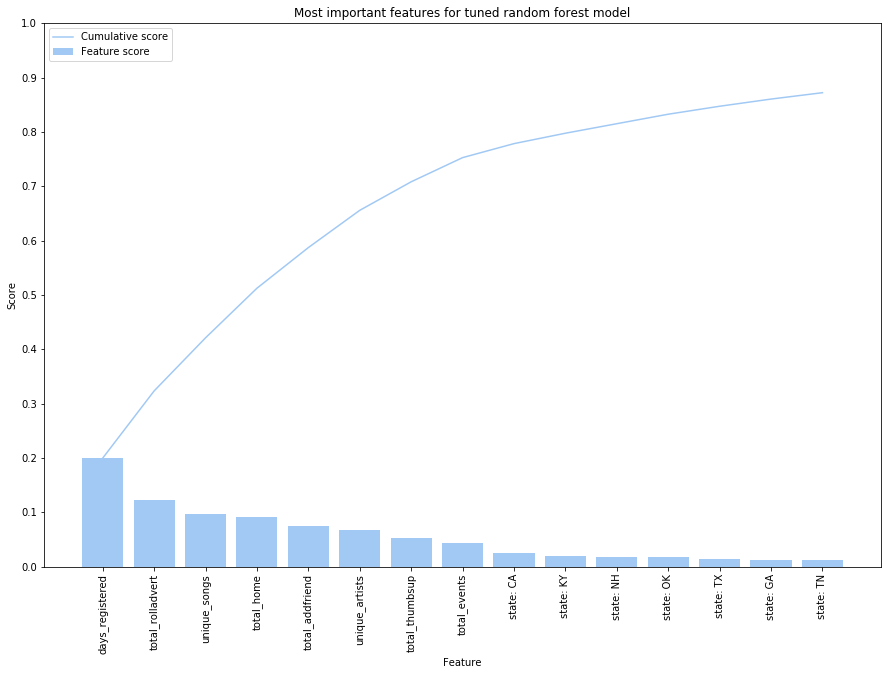

In [33]:
# plot feature score and cumulative score for most important features for tuned random forest model
# keep only top 15 most important features for plotting
df_feat_imp_rf_15 = df_feat_imp_rf.head(15)

ind = np.arange(len(df_feat_imp_rf_15['name']))

fig = plt.figure(figsize = (15,10))
plt.bar(ind, df_feat_imp_rf_15['score'], label='Feature score')
plt.plot(ind, df_feat_imp_rf_15['cumulative_score'], label='Cumulative score')
plt.title('Most important features for tuned random forest model')
plt.legend(loc='upper left')
plt.ylabel('Score')
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xlabel('Feature')
plt.xticks(ind, df_feat_imp_rf_15['name'], rotation=90)
plt.show()

**Above we can see the importance of each feature to the tuned random forest model. The most important features are days_registered, total_rolladvert and unigue_songs, which have a weight of 20%, 12% and 10% respectively. This means that the most important user behaviors to this model in predicting churn are the number of days a user has been registered on the platform, the number of ads they have received and the number of unique songs they listen to.**

**The first 45 most important features have a cumulative weight of 1, which means they add up to a predictive power of 100%. All features shown after these don't add anything to the model, and we could technically simplify the model by removing these and still get the same model performance. This wouldn't make sense in our case though, since all these features belong to the same variable, 'state', and it doesn't make sense to remove some state options from the variable in my opinion.**

**Based on this tuned random forest model, it could be wise for the company to set up an alert system to communicate with a user after a certain number of days to minimize the risk of them canceling their account, look more into finding an optimum number of ads a user can tolerate and build the platform to increase a user's exposure to new songs and artists to improve their experience and keep them on as customers for longer.**

****

**Conclusion:**

**The best f1 score of 69.8% was achieved by using a tuned random forest model (you test the tuned model on the test set as a last step and that's the performance result that matters). Based on this model, the most important user behaviors in predicting churn are the number of days a user has been registered on the platform, the number of ads they have received and the number of unique songs they listen to.**

**To minimize customer churn, the company could set up an alert system to communicate with a user after a certain number of days to minimize the risk of them cancelling their account, look more into finding an optimum number of ads a user can tolerate and build the platform to increase a user's exposure to new songs and artists to improve their experience and keep them on as customers for longer.**

**We didn't really improve the f1 score of our models by training on the bigger dataset, only the linear SVC did comparatively better, which likely confirms our notion that the model needs more examples to train on to find a linear relationship between the input and output variables. We could probably improve our performance and set up our models more properly by training and testing on more examples, this bigger dataset is still considerably small and we don't seem to have enough diverse examples to learn from or test on with only this data available.**

**There are more ways we could improve our models and data quality. For starters, due to our dataset being imbalanced between the classes, we would have benefited from using a bigger dataset or maybe over and under sampling of churned and active user groups to get a more even distribution of examples to train on. We could also use more model performance tools, such as bias-variance plots visualizing how the model train performance compares to its test performance, to simultaneously minimize the bias and variance, two sources of error that prevent models from generalizing beyond the training set. We could also have tried to create other types of input features from the available data to see if these would be more useful in prediction churn and perform some more statistically sound dimensionality reduction or feature selection in the pre-processing, such as PCA or apply a low variance or high correlation filter on the input features to remove unnecessary features or reduce them but still allowing them to convey enough information about the data.**

**We could also have tried removing outliers from the datset to see if this would improve the model performance, but that would have left us with even fewer examples to train on in our case and would probably be suitable only if we have access to more data.**